In [3]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta # 시간차이 계산
import matplotlib.pyplot as plt

# Backtesting

In [4]:
# KOSPI200 데이터
today = dt.datetime.now()
today = dt.datetime(today.year,today.month,today.day); today

test_start_date = dt.date(1999,1,4)
test_end_date = dt.date(2019,1,4)   # 20년 데이터
KOSPI = fdr.DataReader('KS200',test_start_date , test_end_date+relativedelta(years=2)); 
KOSPI_date=  KOSPI.loc[test_start_date:test_end_date].index ;  KOSPI_date  # 코스피 주가의 유효날짜들

DatetimeIndex(['2000-12-26', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-08', '2001-01-09', '2001-01-10',
               '2001-01-11', '2001-01-12',
               ...
               '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-24',
               '2018-12-26', '2018-12-27', '2018-12-28', '2019-01-02',
               '2019-01-03', '2019-01-04'],
              dtype='datetime64[ns]', name='Date', length=4454, freq=None)

In [6]:
# 날짜들

day_list = [ test_start_date + relativedelta(days=i) for i in range( ((test_end_date - test_start_date)).days +1 ) ]; day_list[-1]

five_days_list = [ test_start_date + relativedelta(days=5*i) for i in range( ((test_end_date - test_start_date)).days//5 +1 ) ]; five_days_list[-1]

week_list = [ test_start_date + relativedelta(weeks=i) for i in range( ((test_end_date - test_start_date)/7).days +1 ) ]; week_list[-1]

months_num = ( test_end_date.year - test_start_date.year )*12 - (test_end_date.month - test_start_date.month)
month_list = [ test_start_date + relativedelta(months=i) for i in range( months_num +1 ) ]; month_list[-1];

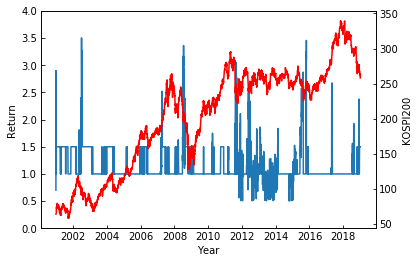

In [7]:
return_list = []

date_list = day_list
# date_list = five_days_list
# date_list = week_list
# date_list = month_list




for idx, i in enumerate(date_list):
    start_date, end_date = i, i+  relativedelta(months = 18)
    
    while start_date not in KOSPI.index:  # 날짜가 없는 경우
        start_date += dt.timedelta(days=1)
        
    date_list[idx] = start_date
        
    while end_date not in KOSPI.index :
        end_date += dt.timedelta(days=1)
    
    
    
    temp_data = KOSPI[start_date : end_date];
    First_price = temp_data.loc[start_date]['Open']
    End_price = temp_data.loc[end_date]['Close']
#     High_price = temp_data.loc[end_date]['High']
#     Low_price = temp_date.loc[end_date]['Low']
#     price_list = temp_data['Close']

    if np.sum(temp_data['High'] > First_price * 1.15 ) > 0:  # 115% 초과?
        case1 = 1
    else : case1 = 0

    if np.sum(temp_data['Close'] < First_price * 0.9 ) > 0:   # 90% 미만?
        case2 = 1
    else : case2 = 0

        
        
    if (case1 == 1) & (case2 == 1):
        _return = 1.5

    elif (case1 == 1) & (case2 == 0):
        if End_price >= First_price:  # 최종가격 상승시
            _return = 1.
        else :                        # 최종가격 하락시
            _return = 1. + (First_price - End_price) / First_price * 17

    elif (case1 == 0) & (case2 == 1):
        if End_price >= First_price: 
            _return = 1. - (First_price - End_price) / First_price * 17
        else :
            _return = 1.
    elif (case1 == 0) & (case2 == 0):
        if End_price >= First_price: 
            _return = .5 - (First_price - End_price) / First_price * 17
        else :
            _return = .5 + (First_price - End_price) / First_price * 17
    return_list.append(_return)
#     print( case1,case2)


# 그래프 그리기
x = date_list
y1 = return_list
y2 = KOSPI.loc[date_list]['High']

fg, ax1 = plt.subplots()

ax1.plot(x, y1)
ax1.set_ylim(0, 18)
ax1.set_xlabel('Year')
ax1.set_ylabel('Return')
ax1.tick_params(axis='both', direction='in')
ax1.set_ylim(0,4)  # y축 범위 제한

ax2 = ax1.twinx()
ax2.plot(x, y2, color='red')
ax2.set_ylabel('KOSPI200')
ax2.tick_params(axis='y', direction='in')


plt.show()


# 몬테카를로 시뮬레이션

https://kosis.kr/statHtml/statHtml.do?orgId=343&tblId=DT_343_2010_S0032

코스피 배당수익률은 1.5로 가정
코스피 수익률은 위에서 사용한 수익률을 가정.

GBM 모형 사용.
ST = S0 * exp( (mu - 0.5 * sigma^2)T + sigma * T^0.5 * z ) 

In [105]:
test_T = len(KOSPI) / 252
mu = np.log( [( KOSPI.iloc[-1]['Close'] - KOSPI.iloc[0]['Open'] ) / KOSPI.iloc[0]['Open'] ] )[0] / test_T ; mu # 연속복리 약 8.4%수익?
q = 0.015
# sigma = KOSPI['Change'].var()**0.5 ; sigma    # 표준편차 약 1.4%.
sigma = 0.1

T = 1.5
M = 1000
dt = T / M

Iter = 10000 

S = np.zeros((Iter,M+1))
S0 = KOSPI.loc['2021-01-04']['Open']
S[:,0]=S0  # 시작가격

for i in range(1,M+1):
    S[:,i] = S[:,i-1] * np.exp( (mu-q - 0.5*(sigma**2) )*dt + sigma*(dt**0.5) * np.random.standard_normal((Iter)) )


In [107]:
test_case1 = np.max(S, axis = 1) > S0*1.15          # 115% 초과?     
test_case2 = ( np.min(S, axis = 1) < S0*0.9 ) * 2   #  90% 미만?     

test_case= test_case2 + test_case1


#  0 :  안정적              1 : 115%만 초과, 90%미만X
#  2 : 90%미만 115%초과X    3 : 115% & 90% 초과


In [108]:
Return = np.zeros(Iter)

Return[ test_case ==0 ] = 0.5 + 17*np.abs( (S[test_case==0][:,-1] - S[test_case==0][:,0])/S[test_case==0][:,0] )
Return[ test_case ==1 ] = 1 + 17*np.max( ( (S[test_case==1][:,0] - S[test_case==1][:,-1])/S[test_case==1][:,0] )[:,np.newaxis], axis=1 , initial=0 )
Return[ test_case ==2 ] = 1 + 17*np.max( ( (S[test_case==2][:,-1] - S[test_case==2][:,0])/S[test_case==2][:,0] )[:,np.newaxis], axis=1 , initial=0 )
Return[ test_case ==3 ] = 1.5


Return


array([1.        , 1.69296922, 1.98388692, ..., 1.        , 1.        ,
       1.52565527])